In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

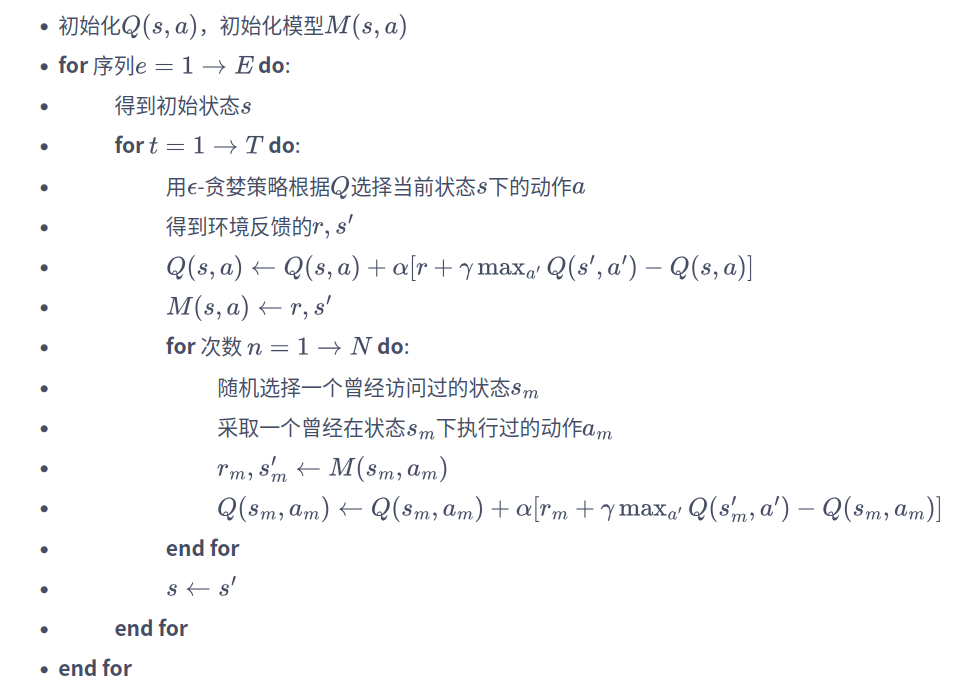  

离线策略学习可以让智能体基于经验回放池中的样本来学习，但需要保证智能体在学习的过程中可以不断和环境进行交互，  
将采样得到的最新的经验样本加入经验回放池中，从而使经验回放池中有一定数量的样本和当前智能体策略对应的数据分布保持很近的距离

这个算法相当于Q_learning的离线与在线的综合，保证采集数据的智能体与被训练的相同，采集到的数据存储下来作为离线经验  
每一步训练包括使用真实数据进行一次Q_learing，使用历史数据进行n次Q_learing  



In [8]:
class DynaQ:
    """ Dyna-Q算法 """
    def __init__(self,ncol,nrow,epsilon,alpha,gamma,n_planning,n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

        self.n_planning = n_planning  #执行Q-planning的次数, 对应1次Q-learning
        self.model = dict()  # 环境的查表模型，对环境的反应有记忆性

    def take_action(self, state):  # 选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def q_learning(self, s0, a0, r, s1):
        TD_target=r + self.gamma * self.Q_table[s1].max()
        td_error = TD_target- self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, s0, a0, r, s1):
        # 与真实环境交互得到的数据
        self.q_learning(s0, a0, r, s1)
        # 将数据添加到模型中
        self.model[(s0, a0)] = r, s1  
        # Q-planning循环
        for _ in range(self.n_planning):  
            # 随机选择曾经遇到过的状态动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)

import random  
random.choice(sequence)  
sequence：一个非空的序列（列表、元组或字符串等可迭代对象）  
返回序列中的一个随机元素  

允许重复，按权重 [10, 1, 1] 选择sequence里面的两个数  
random.choices(sequence, weights=[10, 1, 1], k=2)   

随机选择3个不重复的元素  
random.sample(sequence, 3)  

不能直接对字典使用 choice()，因为字典不是序列  
random_key = random.choice(list(my_dict.keys()))  
random_value = random.choice(list(my_dict.values()))  
random_item = random.choice(list(my_dict.items()))返回一个键值对元组   

In [9]:
def DynaQ_CliffWalking(n_planning,env):
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(env.ncol, env.nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少条序列

    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list,agent

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 3052.25it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1776.54it/s, episode=300, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 330.19it/s, episode=300, return=-13.400]


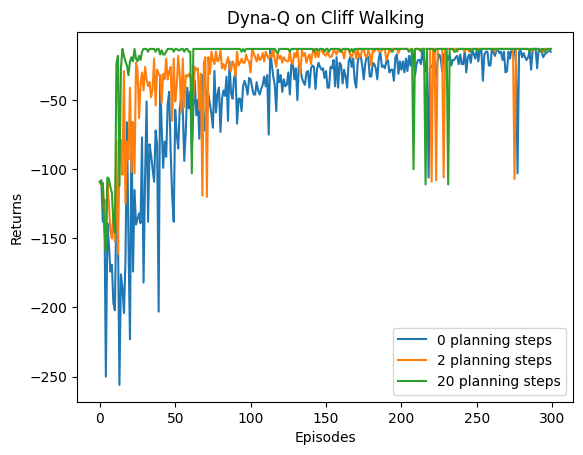

In [10]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
agents=[]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list,agent= DynaQ_CliffWalking(n_planning,env)
    agents.append(agent)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()


In [12]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
for i in range(len(agents)):
    print(f'第{i+1}个agent使用Dyna_Q算法最终收敛得到的策略为：')
    print_agent(agents[i], env, action_meaning, list(range(37, 47)), [47])

第1个agent使用Dyna_Q算法最终收敛得到的策略为：
ooo> ovoo oo<o ooo> ooo> ^ooo ^ooo ooo> ooo> ooo> ooo> ^oo> 
^ooo ovoo ^ooo ooo> ooo> ooo> oo<o ooo> ovoo ovoo ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
第2个agent使用Dyna_Q算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
第3个agent使用Dyna_Q算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
